<a href="https://colab.research.google.com/github/lavitovm/catanddog-classification-CNN/blob/main/Klasifikasi_kucing_dan_anjing_menggunakan_metode_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
base_dir = '/content/drive/My Drive/dataset/'
!ls "/content/drive/My Drive/dataset/"

bahan  latih  validasi


In [3]:
#Menentukan Direktori
bahan_dir = os.path.join(base_dir, 'bahan')
train_dir = os.path.join(base_dir, 'latih')
validation_dir = os.path.join(base_dir, 'validasi')

In [4]:
#menentukan direktori isi bahan
anjing_dir = os.path.join(bahan_dir, 'Anjing/')
kucing_dir = os.path.join(bahan_dir, 'Kucing/')

print("Jumlah Data Train Tiap Kelas")
print("Jumlah Gambar Anjing : ", len(os.listdir(anjing_dir)))
print("Jumlah Gambar Kucing : ", len(os.listdir(kucing_dir)))

Jumlah Data Train Tiap Kelas
Jumlah Gambar Anjing :  70
Jumlah Gambar Kucing :  70


In [5]:
#menentukan direktori isi latih/training
train_anjing = os.path.join(train_dir, 'Anjing/')
train_kucing = os.path.join(train_dir, 'Kucing/')

#menentukan direktori isi validasi
validation_anjing = os.path.join(validation_dir, 'Anjing/')
validation_kucing = os.path.join(validation_dir, 'Kucing/')

Menyiapkan Dataset

In [6]:
import random
from shutil import copyfile

def train_val_split(source, train, val, train_ratio):
  total_size = len(os.listdir(source))
  train_size = int(train_ratio * total_size)
  val_size = total_size - train_size

  randomized = random.sample(os.listdir(source), total_size)
  train_files = randomized[0:train_size]
  val_files = randomized[train_size:total_size]

  for i in train_files:
    i_file = source + i
    destination = train + i
    copyfile(i_file, destination)

  for i in val_files:
    i_file = source + i
    destination = val + i
    copyfile(i_file, destination)

#jumlah pembagian data tarining dan testing
train_ratio = 0.9

#pembagian training dan validasi
#Training
source_00 = anjing_dir
train_00 = train_anjing
val_00 = validation_anjing
train_val_split(source_00, train_00, val_00, train_ratio)

#Validasi
source_01 = kucing_dir
train_01 = train_kucing
val_01 = validation_kucing
train_val_split(source_01, train_01, val_01, train_ratio)

In [7]:
print("jumlah seluruh gambar anjing : ", len(os.listdir(anjing_dir)))
print("jumlah train anjing : ", len(os.listdir(train_anjing)))
print("Jumlah Val anjing : ", len(os.listdir(validation_anjing)))

jumlah seluruh gambar anjing :  70
jumlah train anjing :  341
Jumlah Val anjing :  348


Pre-Processing

In [8]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    horizontal_flip = True,
    shear_range = 0.3,
    fill_mode = 'nearest',
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.1
)

val_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    horizontal_flip = True,
    shear_range = 0.3,
    fill_mode = 'nearest',
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.1
)

Target

In [10]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150,150),
    batch_size = 10,
    class_mode = 'categorical'
)

val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size = (150,150),
    batch_size = 10,
    class_mode = 'categorical'
)

Found 683 images belonging to 2 classes.
Found 697 images belonging to 2 classes.


In [11]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if(logs.get('accuracy') > 0.99):
      print("\n Akurasi mencapai 99%")
      self.model.stop_training = True

callbacks = myCallback()

Model CNN

In [12]:
model = tf.keras.models.Sequential([
          tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu', input_shape = (150, 150, 3)),
          tf.keras.layers.MaxPooling2D(2, 2),
          tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
          tf.keras.layers.MaxPooling2D(2, 2),
          tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
          tf.keras.layers.MaxPooling2D(2, 2),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(200, activation = 'relu'),
          tf.keras.layers.Dropout(0.3, seed=112),
          tf.keras.layers.Dense(500, activation = 'relu'),
          tf.keras.layers.Dropout(0.5, seed=112),
          tf.keras.layers.Dense(2, activation = 'sigmoid')
])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [14]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'Adam',
              metrics = ['accuracy'])

In [15]:
history = model.fit(
    train_generator,
    steps_per_epoch = 6,
    epochs = 25,
    validation_data = val_generator,
    validation_steps = 1,
    verbose = 1,
    callbacks = [callbacks]
)

Epoch 1/25
6/6 [==============================] - 13s 2s/step - loss: 0.7077 - accuracy: 0.6500 - val_loss: 0.6836 - val_accuracy: 0.6000
Epoch 2/25
6/6 [==============================] - 11s 2s/step - loss: 0.7601 - accuracy: 0.5000 - val_loss: 0.7061 - val_accuracy: 0.3000
Epoch 3/25
6/6 [==============================] - 11s 2s/step - loss: 0.6996 - accuracy: 0.5167 - val_loss: 0.7000 - val_accuracy: 0.4000
Epoch 4/25
6/6 [==============================] - 8s 1s/step - loss: 0.7057 - accuracy: 0.4167 - val_loss: 0.6801 - val_accuracy: 0.5000
Epoch 5/25
6/6 [==============================] - 9s 2s/step - loss: 0.7064 - accuracy: 0.4333 - val_loss: 0.6942 - val_accuracy: 0.5000
Epoch 6/25
6/6 [==============================] - 8s 1s/step - loss: 0.6938 - accuracy: 0.5167 - val_loss: 0.6970 - val_accuracy: 0.2000
Epoch 7/25
6/6 [==============================] - 8s 1s/step - loss: 0.6930 - accuracy: 0.5500 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 8/25
6/6 [======================

Tingkat akurasi dan loss model

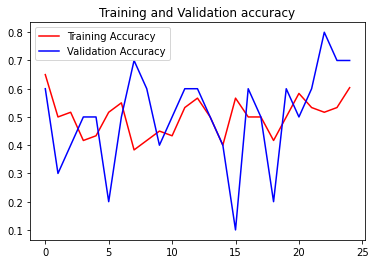

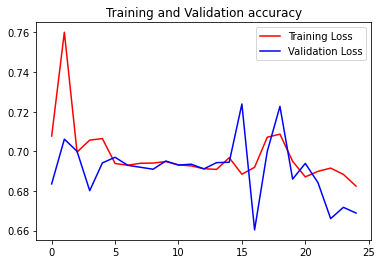

In [16]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation accuracy')
plt.legend(loc = 'best')
plt.show()

plt.plot(epochs, loss, 'r', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training and Validation accuracy')
plt.legend(loc = 'best')
plt.show()

Klasifikasi

In [ ]:
import numpy as np
from keras.preprocessing import image
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():

  path = fn
  img = tf.keras.utils.load_img(path, target_size = (150, 150))
  imgplot = plt.imshow(img)
  x = tf.keras.utils.img_to_array(img)
  x = np.expand_dims(x, axis = 0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size = 100)

  print(fn)

  class_list = os.listdir(train_dir)

  for j in range(43):
    if classes[0][j] == 1. :
      print('This image belongs to class', class_list[j-1])
      break